# Breast Cancer Ultrasound Segmentation


Dataset: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/data

Breast cancer is one of the most common causes of death among women worldwide. Early detection helps in reducing the number of early deaths. The data reviews the medical images of breast cancer using ultrasound scan. Breast Ultrasound Dataset is categorized into three classes: normal, benign, and malignant images. Breast ultrasound images can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

Data
The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from glob import glob

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model

In [4]:
from collections import Counter
import os

dataset_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"
categories = ['benign', 'malignant', 'normal']

for category in categories:
    files = os.listdir(os.path.join(dataset_path, category))
    count = Counter("mask" in f for f in files if f.endswith('.png'))
    print(f"{category}: {count[False]} images, {count[True]} masks, total: {len(files)}")

benign: 437 images, 454 masks, total: 891
malignant: 210 images, 211 masks, total: 421
normal: 133 images, 133 masks, total: 266


In [5]:
# Only include tumor classes (exclude 'normal')
folder_paths = sorted(glob("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*"))
folder_paths = [fp for fp in folder_paths if not fp.lower().endswith("normal")]

In [ ]:
# Reshape images in dataset from (483 x 560 x 3) to (256 x 256 x 1)
size = 256

In [9]:
# Empty list for images 
images = []

# Empty list for masks  
masks = []

## Combine multiple ground truth images for same Image

In [ ]:
found_mask = False

# Loop through only benign + malignant
for folder_path in folder_paths:
    files = sorted(glob(folder_path + '/*.png'))

    for file_path in files:
        filename = os.path.basename(file_path)

        # Load and preprocess image
        img = cv2.imread(file_path)

        # Skip unreadable files
        if img is None:
            print(f"Skipping unreadable file: {filename}")
            continue

        img = cv2.resize(img, (size, size))               # Resize image to (256 x 256)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)       # Convert RGB to grayscale

        # Normalize to [0, 1]
        img = img / 255.0

        # Check if file is a mask
        if 'mask' in filename.lower():
            if found_mask:
                # Combine with prev mask (Add pixel values i.e 1s and 0s) of current mask with prev mask
                masks[-1] += img

                # Set all pixel values that are > 0.5 to 1, and all pixel values that are < 0.5 to 0
                masks[-1] = np.where(masks[-1] > 0.5, 1.0, 0.0)
                
            else:
                # Save masked images in the list 'masks' & set flag to True
                masks.append(img)
                found_mask = True
        else:
            # Add original image in the list 'images'
            images.append(img)
            found_mask = False          # prepare for next image–mask pair

In [11]:
# Convert list to NumPy arrays
X = np.array(images).reshape(-1, size, size, 1)
y = np.array(masks).reshape(-1, size, size, 1)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (647, 256, 256, 1)
y shape: (647, 256, 256, 1)


In [12]:
# Train-test split (80% - training, 20% - testing)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

---

## U-Net Architecture

In [67]:
# ENCODER 

input_layer = Input(shape=(size, size, 1))  # (256, 256, 1)

# 1st encoder block
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input_layer)  # 64 filters of size (3, 3)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)  # pool the feature maps with max pooling, using (2 x 2) window with stride length of 2
drop1 = Dropout(0.2)(pool1)

# 2nd encoder block
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)
drop2 = Dropout(0.2)(pool2)

# 3rd encoder block
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)
drop3 = Dropout(0.3)(pool3)

# 4th encoder block
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
pool4 = MaxPooling2D((2, 2))(conv4)
drop4 = Dropout(0.3)(pool4)

# 5th encoder block
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
pool5 = MaxPooling2D((2, 2))(conv5)
drop5 = Dropout(0.3)(pool5)

# BOTTLENECK
bottleneck = Conv2D(2048, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop5)
bottleneck = Conv2D(2048, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(bottleneck)

In [ ]:
# DECODER

# 1st decoder block
upconv1 = Conv2DTranspose(1024, (2, 2), strides=2, padding='same')(bottleneck)  # upsampling, by using transposed convolution with a (2 x 2) window
concat1 = concatenate([upconv1, conv5])  # concatenate the corresponding feature maps
conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(concat1)  # perform convolution of the concatenated feature maps,
conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
drop6 = Dropout(0.3)(conv6)

# 2nd decoder block
upconv2 = Conv2DTranspose(512, (2, 2), strides=2, padding='same')(drop6)
concat2 = concatenate([upconv2, conv4])
conv7 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(concat2)
conv7 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
drop7 = Dropout(0.3)(conv7)

# 3rd decoder block
upconv3 = Conv2DTranspose(256, (2, 2), strides=2, padding='same')(drop7)
concat3 = concatenate([upconv3, conv3])
conv8 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(concat3)
conv8 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
drop8 = Dropout(0.2)(conv8)

# 4th decoder block
upconv4 = Conv2DTranspose(128, (2, 2), strides=2, padding='same')(drop8)
concat4 = concatenate([upconv4, conv2])
conv9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(concat4)
conv9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
drop9 = Dropout(0.2)(conv9)

# 5th decoder block
upconv5 = Conv2DTranspose(64, (2, 2), strides=2, padding='same')(drop9)
concat5 = concatenate([upconv5, conv1])
conv10 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(concat5)
conv10 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
drop10 = Dropout(0.2)(conv10)

# O/P layer
output_layer = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(drop10)  # 1 filter of size (1 x 1)

In [70]:
# Model creation
model = Model(inputs = input_layer, outputs = output_layer)

In [71]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 256, 256, 64)   │            640 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_73[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 128, 128, 64)   │              0 │ conv2d_74[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_75[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 64, 64, 128)    │              0 │ conv2d_76[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ max_pooling2d_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_77[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 32, 32, 256)    │              0 │ conv2d_78[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 256)    │              0 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_79[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 16, 16, 512)    │              0 │ conv2d_80[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 512)    │              0 │ max_pooling2d_21[0][0] │
├──────────────────────

 Total params: 124,361,025 (474.40 MB)

 Trainable params: 124,361,025 (474.40 MB)

 Non-trainable params: 0 (0.00 B)

---

## Loss function

In [ ]:
# Dice Loss
def dice_loss(y_true, y_pred, smooth = 1):

    y_true_f = tf.keras.backend.flatten(y_true)  # Flatten ground truth mask
    y_pred_f = tf.keras.backend.flatten(y_pred)  # Flatten predicted mask
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Calculate intersection
    
    # Dice coefficient formula (with smoothing to avoid division by zero)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [ ]:
# Combined Binary Crossentropy + Dice Loss (for both pixel-wise accuracy & overlap)
def bce_dice_loss(y_true, y_pred):

    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)  
    return bce + dice_loss(y_true, y_pred)  

---

## Model Compilation

In [ ]:
from tensorflow.keras.optimizers import Adam

learning_rate = 2e-4  # Initially 1e-4
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss = bce_dice_loss, optimizer = optimizer, metrics = ['accuracy'])

---

## Data Augmentation

In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [78]:
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [79]:
seed = 42
batch_size = 8

In [80]:
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

In [81]:
def train_generator():
    while True:
        X_batch = image_generator.next()
        y_batch = mask_generator.next()
        yield X_batch, y_batch

---

## Model Training

In [82]:
# EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor = 'val_loss',      
    patience = 8,  # epochs to wait for improvement
    restore_best_weights = True
)

In [ ]:
history = model.fit(X_train, 
          y_train, 
          epochs = 50, 
          batch_size = 8,  # initially batch_size = 16
          validation_data = (X_val, y_val), 
          callbacks = [early_stopping],
          verbose = 1)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 58s 520ms/step - accuracy: 0.8988 - loss: 1.3076 - val_accuracy: 0.9064 - val_loss: 1.2112
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - accuracy: 0.9033 - loss: 1.1917 - val_accuracy: 0.9072 - val_loss: 1.1871
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - accuracy: 0.8994 - loss: 1.1682 - val_accuracy: 0.9070 - val_loss: 0.9903
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - accuracy: 0.8979 - loss: 0.9834 - val_accuracy: 0.9176 - val_loss: 0.9372
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - accuracy: 0.9136 - loss: 0.8124 - val_accuracy: 0.9240 - val_loss: 0.8258
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - accuracy: 0.9240 - loss: 0.7785 - val_accuracy: 0.9307 - val_loss: 0.7575
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - accuracy: 0.9263 - loss: 0.6823 - val_accuracy: 0.9307 - val_loss: 0.7120
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - accuracy: 0.9285 - loss: 0.6981 - val_accu

---

## Plot

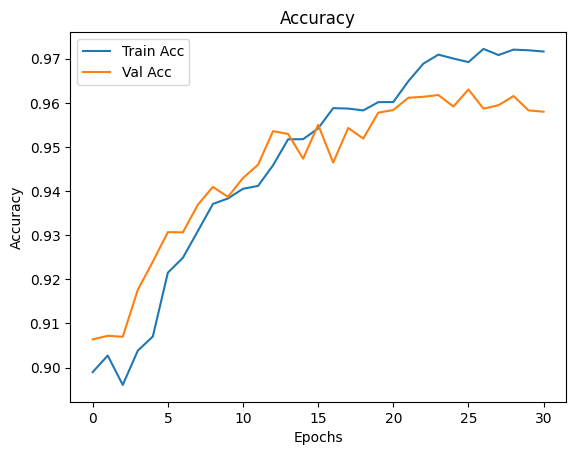

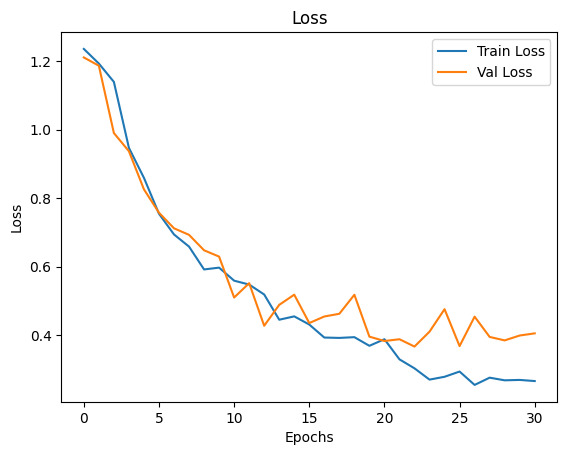

In [84]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(), plt.title("Accuracy"), plt.xlabel("Epochs"), plt.ylabel("Accuracy")
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(), plt.title("Loss"), plt.xlabel("Epochs"), plt.ylabel("Loss")
plt.show()

## Intersection over Union (IoU) Score

In [85]:
from sklearn.metrics import jaccard_score

# Compute predicted mask
pred = model.predict(X_val, verbose = 1)
pred = (pred > 0.5).astype(int)       # Binarize (O/P from the predictions will be probability values btw 0 & 1, so we convert these probabilities to 0s and 1s)

y_true = y_val.astype(int)

# Compute IoU based on flatten predictions and ground truths
iou = jaccard_score(pred.flatten(), y_true.flatten())  # jaccard_score() expects 1D arrays, hence .flatten()
print(f'IoU (Jaccard Score): {iou:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step
IoU (Jaccard Score): 0.6560


In [86]:
# Mean IoU
from keras.metrics import MeanIoU

mean_iou = MeanIoU(num_classes = 2)
mean_iou.update_state(pred, y_true)

print('Mean IoU: ', mean_iou.result().numpy())

Mean IoU:  0.8080264


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


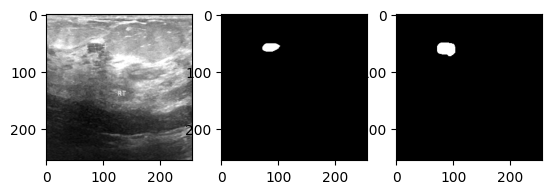

In [87]:
# Visualise 
i = 6
plt.subplot(1, 3, 1)
plt.imshow(X_val[i], cmap = 'gray')           # original image in grayscale

plt.subplot(1, 3, 2)
plt.imshow(y_val[i], cmap = 'gray')           # ground truth mask

plt.subplot(1, 3, 3)

# Predicted mask
pred = model.predict(np.expand_dims(X_val[i], axis = 0), verbose =1)[0]

pred = (pred > 0.5)       # Binarize 
plt.imshow(pred, cmap = 'gray')

In [88]:
# Print final metrics after training and evaluation
print("Final Training Accuracy: {:.4f}".format(history.history['accuracy'][-1]))
print("Final Validation Accuracy: {:.4f}".format(history.history['val_accuracy'][-1]))
print("Final Training Loss: {:.4f}".format(history.history['loss'][-1]))
print("Final Validation Loss: {:.4f}".format(history.history['val_loss'][-1]))
print("IoU (Jaccard Score): {:.4f}".format(iou))
print("Mean IoU: {:.4f}".format(mean_iou.result().numpy()))

Final Training Accuracy: 0.9716
Final Validation Accuracy: 0.9580
Final Training Loss: 0.2656
Final Validation Loss: 0.4050
IoU (Jaccard Score): 0.6560
Mean IoU: 0.8080
